In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
target = "TotalGHGEmissions"

# Mise en place d'une fonction de calcul de metrique d'erreur

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error

Cette fonction doit permettre de changer de métrique sans changer trop de code, ainsi que d'enregistrer les différents résultats dans un dataframe

In [4]:
saved_errors = pd.DataFrame(columns=['Modèle', 'MSE', 'Med_abs_error', 'mean_abs_error'])

In [5]:
def error_metric(modele_name, y_test, y_predict, saved=False):
    #Calcul des métriques : 
    mse = np.sqrt(mean_squared_error(y_test, y_predict))
    mae = median_absolute_error(y_test, y_predict)
    mean_abs_error = mean_absolute_error(y_test, y_predict)
    #Enregistrement dans un dataframe
    if saved == True:
        err = [modele_name, mse, mae, mean_abs_error]
        saved_errors.loc[len(saved_errors)] = err
    #Return la métrique
    return mae

# Import des données

In [6]:
data_quanti = pd.read_csv('files_cleaned/data_quanti.csv')
data_quali = pd.read_csv('files_cleaned/data_quali.csv')
data_quanti = data_quanti.drop(columns=['Unnamed: 0'])

In [7]:
data_quanti = data_quanti.dropna(subset=[target])

In [8]:
x = data_quanti.drop(columns=["SiteEnergyUseWN(kBtu)", "TotalGHGEmissions",
                              "SiteEnergyUse(kBtu)",
                              'ENERGYSTARScore', 'GHGEmissionsIntensity', 
                              'Electricity(kWh)', 'Electricity(kBtu)',
                              'NaturalGas(kBtu)', 'NaturalGas(therms)',
                              'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)',
                              'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                              'SteamUse(kBtu)', 'OSEBuildingID', 'DataYear'])
y = data_quanti[[target]]
energy = data_quanti[['ENERGYSTARScore', 'GHGEmissionsIntensity', 
                      'Electricity(kWh)', 'Electricity(kBtu)',
                      'NaturalGas(kBtu)', 'NaturalGas(therms)',
                      'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)',
                      'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                      'SteamUse(kBtu)', "SiteEUI(kBtu/sf)"]]

In [9]:
x = x.fillna(x.mean())
y = y.astype(int)

# Division des datasets en deux 

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

On standardise les données 

In [12]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(x_train)
x_train = std_scale.transform(x_train)
x_test = std_scale.transform(x_test)  

In [13]:
x_train.shape

(5281, 12)

# Mise en place d'une baseline

In [14]:
reg_simple = sm.OLS(y_train, x_train).fit()

In [15]:
y_predict = reg_simple.predict(x_test)

In [16]:
baseline_error = error_metric('baseline', y_test, y_predict, saved=True)
baseline_error

125.27796984588544

In [17]:
saved_errors

,Modèle,MSE,Med_abs_error,mean_abs_error
0,baseline,409.048222,125.27797,157.58204


# Modèles linéaires 

## Regression Ridge

In [18]:
n_alphas = 200
alphas = np.logspace(-5, 5, n_alphas)

In [19]:
from sklearn import linear_model
from sklearn.linear_model import Ridge

ridge = linear_model.Ridge()

alph = []
coefs = []
errors = []
for a in alphas:
    alph.append(a)
    ridge.set_params(alpha=a)
    ridge.fit(x_train, y_train)
    coefs.append(ridge.coef_)
    y_predict = ridge.predict(x_test)
    errors.append([baseline_error, 
                   error_metric('Ridge', y_test, y_predict, saved=False)])

In [20]:
#On récupère l'alpha de l'erreur minimale et on les injecte dans une régression Ridge
#On fait ensuite une prédiction et on sauvegarde nos métriques 
a = alph[errors.index(min(errors))]
ridge.set_params(alpha=a)
ridge.fit(x_train, y_train)
y_predict = ridge.predict(x_test)
error_metric('Ridge', y_test, y_predict, saved=True)

24.849644404981944

La regression Ridge est meilleure que la regression normale, cependant la mean squared error reste extrêmement élevée

## Regression Lasso

In [21]:
n_alphas = 1000
alphas = np.logspace(-5, 5, n_alphas)
lasso = linear_model.Lasso(fit_intercept=False)

alph = []
coefs = []
errors = []
for a in alphas:
    alph.append(a)
    lasso.set_params(alpha=a)
    lasso.fit(x_train, y_train)
    coefs.append(lasso.coef_)
    y_predict = lasso.predict(x_test)
    errors.append([baseline_error, 
                   error_metric('Lasso', y_test, y_predict, saved=False)])

C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jpaul\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

In [22]:
#On récupère l'alpha de l'erreur minimale et on les injecte dans une régression Lasso
#On fait ensuite une prédiction et on sauvegarde nos métriques 
a = alph[errors.index(min(errors))]
lasso.set_params(alpha=a)
lasso.fit(x_train, y_train)
y_predict = lasso.predict(x_test)
error_metric('Lasso', y_test, y_predict, saved=True)

31.0

La régression Lasso est meilleure que la régression simple, cependant elle est moins bonne que la régression Ridge

## Regression ElasticNet

# Modèles non linéaires 

## KRR

Initialisation du modèle

In [23]:
from sklearn import kernel_ridge
predicteur = kernel_ridge.KernelRidge(
    alpha=1.0, # valeur par défaut 
    kernel='rbf', # noyau Gaussien
    gamma=0.01)   # valeur de 1/(2 * sigma**2)
                                     
# entraîner le classifieur sur le jeu d'entrainement
predicteur.fit(x_train, y_train)

# prédire sur le jeu de test
y_predict = predicteur.predict(x_test)

# calculer la RMSE sur le jeu de test
error_metric('KRR', y_test, y_predict, saved=False)

20.39338124005144

La MSE est ici inférieur à notre baseline et à la regression Ridge, le modèle est donc amélioré. Cependant cette dernière reste très élevée

Testons avec une boucle sur alpha :

In [24]:
n_alphas = 200
alphas = np.logspace(-5, 5, n_alphas)

alph = []
errors = []

for a in alphas : 
    alph.append(a)
    predicteur = kernel_ridge.KernelRidge(
        alpha=a, # valeur par défaut 
        kernel='rbf', # noyau Gaussien
        gamma=0.01)   # valeur de 1/(2 * sigma**2)
    
    # entraîner le classifieur sur le jeu d'entrainement
    predicteur.fit(x_train, y_train)

    # prédire sur le jeu de test
    y_predict = predicteur.predict(x_test)

    # calculer la MSE sur le jeu de test
    errors.append([baseline_error, 
                   error_metric('KRR', y_test, y_predict, saved=False)])

In [25]:
#On récupère l'alpha de l'erreur minimale et on les injecte dans une régression KRR
#On fait ensuite une prédiction et on sauvegarde nos métriques 
a = alph[errors.index(min(errors))]
predicteur = kernel_ridge.KernelRidge(
        alpha=a, # valeur par défaut 
        kernel='rbf', # noyau Gaussien
        gamma=0.01)   # valeur de 1/(2 * sigma**2)
predicteur.fit(x_train, y_train)
y_predict = predicteur.predict(x_test)
error_metric('KRR', y_test, y_predict, saved=True)

15.145765729829172

L'erreur est ici bien plus basse, le modèle est donc bien plus performant ! 

## Random Forest 

Préparation des données 

In [26]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

On commence avec une random forest sans cross-validation

In [27]:
from sklearn.ensemble import RandomForestRegressor

Initialisation du modèle avec 1000 arbres 

In [28]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(x_train, y_train)

C:\Users\jpaul\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Prédictions et métrique d'erreur

In [29]:
# Use the forest's predict method on the test data
y_predict = rf.predict(x_test)

# Calcul Metrique d'erreur
error_metric('Random Forest', y_test, y_predict, saved=True)

10.257000000000005

Amélioration du modèle 

In [30]:
from sklearn.feature_selection import SelectFromModel

In [31]:
select = SelectFromModel(rf, prefit=True, threshold=0.003)
x_train2 = select.transform(x_train)
print(x_train2.shape)

(5281, 12)


Deux features ont été enlevées

In [32]:
x_test2 = select.transform(x_test)

In [33]:
rf.fit(x_train2, y_train)
y_predict = rf.predict(x_test2)
error_metric('Random_forest Opti', y_test, y_predict, saved=True)

C:\Users\jpaul\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


10.257000000000005

Le modèle est amélioré

# Résultats 

In [34]:
saved_errors

,Modèle,MSE,Med_abs_error,mean_abs_error
0,baseline,409.048222,125.277970,157.582040
1,Ridge,427.283278,24.849644,79.856512
2,Lasso,540.164322,31.000000,120.034822
3,KRR,537.232680,15.145766,109.957911
4,Random Forest,185.255306,10.257000,38.207665
5,Random_forest Opti,185.255306,10.257000,38.207665


### Plot prédictions/réelles

Scatter plot à revoir

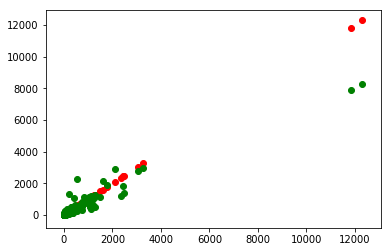

In [35]:
plt.scatter(y_test, y_test, color = "red")
plt.scatter(y_test, y_predict, color = "green")
#plt.title("Valeurs réelles vs valeurs prédites")
#plt.xlabel("Years of Experience")
#plt.ylabel("Salary")
plt.show()

# Aller plus loin : Réseau de Neurones

In [36]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [37]:
"""import timeit

start_time = timeit.default_timer()

def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, x_train, y_train, cv=kfold)
print("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))

elapsed = timeit.default_timer() - start_time

print("Time:", elapsed)"""

'import timeit\n\nstart_time = timeit.default_timer()\n\ndef larger_model():\n    # create model\n    model = Sequential()\n    model.add(Dense(12, input_dim=12, kernel_initializer=\'normal\', activation=\'relu\'))\n    model.add(Dense(6, kernel_initializer=\'normal\', activation=\'relu\'))\n    model.add(Dense(6, kernel_initializer=\'normal\', activation=\'relu\'))\n    model.add(Dense(1, kernel_initializer=\'normal\'))\n    # Compile model\n    model.compile(loss=\'mean_squared_error\', optimizer=\'adam\')\n    return model\n\n# evaluate model with standardized dataset\nestimators = []\nestimators.append((\'standardize\', StandardScaler()))\nestimators.append((\'mlp\', KerasRegressor(build_fn=larger_model, epochs=50, batch_size=5, verbose=0)))\npipeline = Pipeline(estimators)\nkfold = KFold(n_splits=10)\nresults = cross_val_score(pipeline, x_train, y_train, cv=kfold)\nprint("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))\n\nelapsed = timeit.default_timer() - start_time\n\

Point à revoir en détail (code juste copié et débuggué) <br/>
Source : 